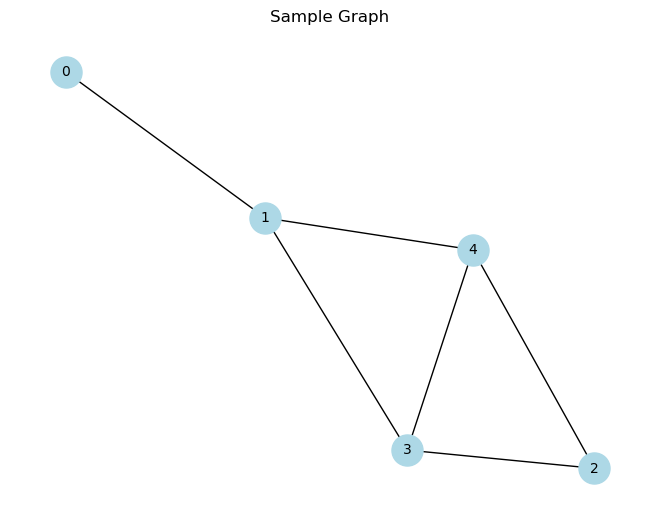

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
def generate_graphlet(input):             #input: a graph
    graphs = []
    new_graphs = [g for g in nx.graph_atlas_g() if len(g.nodes())==input]

    for graph in new_graphs:
        if len(list(nx.connected_components(graph))) == 1:      #reject the graph with is not connected (would not be the graphlet)
            graphs.append(graph)
    return graphs
graphs = generate_graphlet(5)
nx.draw(graphs[9], with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
plt.title("Sample Graph")
plt.show()

In [2]:
G = graphs[9]

# Function for SRW on G(d)

In [3]:
import random
import queue

# Functions for SRW on G(d)

# A state is a graph with d nodes. We repersent it as a nx.Graph(). Noted the differnt of currect_state, walking_state, and next_state.

# State operation

def remove_random_node(current_state):
    nodes = list(current_state.nodes())
    node_removed = random.choice(nodes)
    walking_state = current_state.copy()
    walking_state.remove_node(node_removed)
    return walking_state, node_removed

# find possible node can be added for each node in a state
def find_all_possible_new_node(current_state):
    nodes = list(current_state.nodes())
    candidate_nodes_dict = {}
    for node in nodes:
        # neighbors is a list
        neighbors = list(G.neighbors(node))
        candidate_nodes_dict[node] = [x for x in neighbors if x not in nodes]
    return candidate_nodes_dict

# return all possible walking state
def find_all_possible_walking_state(current_state):

    nodes = list(current_state.nodes())
    possible_walking_states = []

    if len(nodes) == 1:
        possible_walking_states.append(current_state)
        return possible_walking_states

    for node in nodes:
        walking_state = current_state.copy()
        walking_state.remove_node(node)
        possible_walking_states.append(walking_state)
    return possible_walking_states

# check if the walking state any disconnection
def subgraph_counting(walking_state):
    subgraph_listing = list(nx.connected_components(walking_state))
    return subgraph_listing, len(subgraph_listing)

# just validation, doesn't return a new state!
def walking_validation(walking_state, newnode, newedges, degree_req = 0):
    
    if degree_req != 0:
        if len(newedges) < degree_req:
            return False
    
    checking_state = walking_state.copy()
    checking_state.add_node(newnode)
    checking_state.add_edges_from(newedges)
    
    if len(list(nx.connected_components(checking_state))) == 1:
        return newedges
    else:
        return False


In [107]:
def extract_valid_new_state(current_state, G):

    candidate_nodes_dict = find_all_possible_new_node(current_state)

    possible_walking_states = find_all_possible_walking_state(current_state)

    drop_add_list, edges_list = [], []

    for walking_state in possible_walking_states:
        if len(possible_walking_states) == 1:
            missing_node = list(walking_state.nodes())[0]
            remining_nodes = list(walking_state.nodes())
        else:
            missing_node = (set(current_state.nodes()) - set(walking_state.nodes())).pop()
            remining_nodes = list(walking_state.nodes())
        checked_candidate = []
        for node_remained in remining_nodes:
            for newnode in candidate_nodes_dict[node_remained]:
                    newedges = [(newnode, v) for newnode, v in G.edges(newnode) if v in walking_state]
                    if newnode not in checked_candidate:
                        checked_candidate.append(newnode)
                        if walking_validation(walking_state, newnode, newedges):
                            drop_add_list.append((missing_node, newnode))
                            edges_list.append(newedges)

    return drop_add_list, edges_list


# Functions for line #3

In [5]:
# Functions for line #3, walk l step to get the initial state X(l)

# We have consider use a nx.Graph() represent the X(l), that contain information about the edge (H) connecting different state.
# However, we found that the links between states are prevented and are not nessary information, what important is the squence.
# We can use only the list to store the X(l) instead of nx.Graph().
# So we will have a list of nx.Graph() instead of graph of graph for X(l).
# In that sence, for line #6, we don't need to reconstruct graphlet by refering to the original G. But we can reconstruct the graphlet by only refering to X(l).

# Here are function for intializing first state X1. We first randomly pick a node and perfrom random walk to find d distinct node for X1,
# there could be repeat node during the random walk resulting not enough distinct elements, so it keep walking until the last d node are all distinct.
# We observed that this method will not yeild a uniform selection for X1 on G(d). However, the paper claim that as the estimation 
# will converage despite any intial X1 and even X(l), Marco suggested that non-uniform selection is not a problem 
# and our uniform selection methods via combination was not performed.

def SingleNode_SRW(node, G, previous_node=False):
    # Here you can see a complete non-backtracking(NB) random walk intialization logic. You will not see a single NB function for 
    # extented markov chain because sperated function can help us perform two type of SRW (SRW vs NBSRW) for performance comparsion, but here I write them tgt in 
    # single function SingleNode_SRW because it imporve the efficiency of generating X1 and we don't need comparsion for SRW and NBSRW here.
    neighbors = list(G.neighbors(node))
    if len(neighbors) == 1:
        return neighbors[0]
    if previous_node:
        neighbors.remove(previous_node)
    random_neighbor = random.choice(neighbors)
    return random_neighbor

# Initializing X1 (the first state with d nodes) for the initial state X(l), where l = k - d + 1.
def initialize_X1(G, d):
    if d > len(list(G.nodes())):
        raise ValueError("Parameter must be lower than the number of nodes in original graph.")
    x1_node = []
    # initailize node via sigle node simple random walk
    node = random.choice(list(G.nodes()))
    x1_node.append(node)
    while True:
        node = SingleNode_SRW(node, G)
        x1_node.append(node)
        if len(set(x1_node[-d:])) == d:
            break
    x1 = nx.Graph()
    x1.add_nodes_from(x1_node[-d:])
    for node in x1_node[-d:]:
        edges = [(newnode, v) for newnode, v in G.edges(node) if v in x1]
        x1.add_edges_from(edges)

    return x1

In [134]:
from collections import deque

# Here are function for initialize X(l). Since we now have X1, we can generate X(l) via SRW on G(d).

# This function integrate SRW and NBSRW controlled by if the pervious_transfor provided.
def SRW(X, G, pervious_transfor=False, NB=False):

    state = X.copy()
    srw = extract_valid_new_state(state, G)

    if NB and pervious_transfor:

        a, b = pervious_transfor
        node_operation = (b, a)
        i = srw[0].index(node_operation)
        srw[0].pop(i)
        edges = srw[1].pop(i)

        # be careful that if degree = 1 for current state, walk back to pervous state.
        if len(srw[0]) == 0:

            state.remove_node(node_operation[0])
            state.add_node(node_operation[1])
            if len(list(state.nodes())) > 1:
                state.add_edges_from(edges)

            return state, node_operation
    
    path = random.randint(0, len(srw[0])-1)
    node_operation = srw[0][path]
    edges = srw[1][path]
    state.remove_node(node_operation[0])
    state.add_node(node_operation[1])
    if len(list(state.nodes())) > 1:
        state.add_edges_from(edges)

    return state, node_operation


# This initialzation will also intialize the subgraph induced by X(l).
def initialize_Xl_and_induced_subgraph(X1, G, k, X=nx.Graph()):
    
    d = len(list(X1.nodes()))
    if not d < k:
        raise ValueError("d >= k.")
    # The length of X(l)
    l = k - d + 1

    X = X1.copy()
    Xl = deque(maxlen=l)
    induced_subgraph=nx.Graph()
    
    Xl.append(X)
    induced_subgraph.update(X)
    pervious_transfor=False
    
    for _ in range(l-1):
        # same as X1 intialization, it is NB intialization, pervious_transfor will be provided onec walk.
        X, pervious_transfor = SRW(X, G, pervious_transfor, True)
        Xl.append(X)
        induced_subgraph.update(X)

    return Xl, X, pervious_transfor, induced_subgraph

In [157]:
x1 = initialize_X1(G, 4)
x1.nodes()

NodeView((2, 4, 1, 3))

In [158]:
xl, x, pervious_transfor, induced_subgraph = initialize_Xl_and_induced_subgraph(x1, G, k=5)

In [159]:
induced_subgraph.nodes()

NodeView((2, 4, 1, 3, 0))

In [160]:
for state in xl:
    print(state.nodes())

[2, 4, 1, 3]
[2, 4, 1, 0]


In [161]:
# There could be more than one method to check the graphlet induced by X(l),
# Firstly, we can identify each graplet by just looking at degree combination in that subgraph. (permutation is not important because of the isomorphic nature)
# 1. extract a set of all distinct node from X(l) and count their degree connect to other nodes in that set accorardiing to original graph.
# 2. recontruct subgraph induced by X(l) and count degree for each node.

# We adopt the second method. But we will encounter an issue with how to utilize queue applied during X(l) random walk. 
# Because the recontruction of subgraph induced by X(l) required to check all state in X(l)
# Max suggested that we can maintain the graph during X(l) random walk. In that way we only need to add new state added to X(l) and delete the oldest state deleted in X(l).
# Thus don't need to recontruct the whole subgraph after each walk (i.e. don't need to check state not at the end of the queue)

# After coding Max found that there are some issue, we can not easily delete node from the oldest state because the node may still remain in other 
# state inside the queue. One way to solve that is keep counting the remaining node inside the queue, when it go to zero then we can ensure that
# the node is completely removed from the queue. 
# We didn't implement that but. We go back to list.

# Function for lines #8, 9

In [162]:
# recontruct subgraph indeuced by X(l)
def subgraph_induced(xl):
    subgraph = nx.Graph()
    for x in xl:
        subgraph.update(x)
    return subgraph

In [163]:
# If want to perform NBSRW, just simply give pervious transfor and NB=True.
def extented_markov_chain(x, xl, pervious_transfor=False, NB=False):
    x, pervious_transfor = SRW(x, G, pervious_transfor, NB)
    xl.append(x)
    induced_subgraph = subgraph_induced(xl)
    return x, xl, pervious_transfor, induced_subgraph

In [164]:
x.nodes()

NodeView((2, 4, 1, 0))

In [166]:
while True:
    x, xl, pervious_transfor, induced_subgraph = extented_markov_chain(x, xl, pervious_transfor, True)

KeyboardInterrupt: 

In [181]:
x, xl, pervious_transfor, induced_subgraph = extented_markov_chain(x, xl, pervious_transfor, True)

In [182]:
induced_subgraph.nodes()

NodeView((1, 2, 0, 4, 3))

In [183]:
for state in xl:
    print(state.nodes())

[1, 2, 0, 4]
[1, 2, 4, 3]
